# Mobile Robotics Project - Controlling Thymio
The following report details how the Thymio robot was controlled through an obstacle filled course with sudden local obstacles added. A camera was implemented to create a map and track the position and orientation of the robot. These variables were then processed through a Kalman Filter combining odometry to output the necessary variables for a PID controller to direct the mobile robot. 

In [1]:
!pip install tqdm scipy

In [2]:
#The exclamation point (!) allow to execute a terminal command in the notebook:
!python -m tdmclient list

id:         608f09df-b044-4573-8414-efa666631e72
group id:   9df3dfba-c202-4f95-b536-cdb7d6c1bf83
type:       1 (Thymio II wireless)
product id: 8 (Thymio II)
name:       70
status:     2 (available)
cap:        3
firmware:   14



In [3]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 608f09df-b044-4573-8414-efa666631e72

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from heapq import heappush, heappop # used if you want to use heap queue for priority queue (easier to implement) but not compulsory
from scipy.signal import find_peaks
from tqdm import tqdm
import time

## 1. Vision Processing
The vision system takes the images captured by the camera and locates the robot, obstacles, goal and start position.

In [5]:
# Define a class for circles
class Circle:
    def __init__(self, center, radius, color):
        self.center = center  # Center position as a tuple (x, y)
        self.radius = radius  # Radius as a float
        self.color = color    # Color as a tuple (B, G, R)

    def isColorMatching(self, ref_color):
        # Color distance
        ref_color = np.array(ref_color)
        dmax = 30 # max eculidian distance for the color to be considered equivalent
        d = distance(self.color[0], ref_color[0])

        return d <= dmax

    def __repr__(self):
        return f"Circle(center={self.center}, radius={self.radius}, color={self.color})"
    

# Function to compute euclidian distance between two colors
def distance(vec1, vec2):
    vec1 = np.array(vec1, dtype=np.int32)  # Ensure values are floats
    vec2 = np.array(vec2, dtype=np.int32)
    return np.linalg.norm(vec1 - vec2)

# Function to compute the median point between two circles
def circles_med(circle1, circle2):
    x1, y1 = circle1.center
    x2, y2 = circle2.center

    median_x = (x1 + x2)/2
    median_y = (y1 + y2)/2

    return (median_x, median_y)

def robot_angle(green_center, red_center):
    red_center = np.array(red_center, dtype=np.int32)  # Ensure values are floats
    green_center = np.array(green_center, dtype=np.int32)
    x_r, y_r = red_center
    x_g, y_g = green_center
    
    # Calculate the direction vector
    dx = x_g - x_r
    dy = y_g - y_r
    
    # Compute the angle in radians
    angle_radians = np.arctan2(dy, dx)
    
    return angle_radians
    
def detect_squares(frame, ref_color):
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    blur = cv2.bilateralFilter(frame_hsv,9,75,75)
    # Convert the frame to float for precise computation
    frame_float = frame_hsv.astype(np.float32)
    # Compute the Euclidean distance from the reference color
    ref_color = np.array(ref_color, dtype=np.float32)
    distance = np.sqrt(np.sum((frame_float - ref_color) ** 2, axis=-1))

    # Threshold the image to isolate blue regions
    dmax = 50
    mask = (distance <= dmax).astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(frame, contours, -1, (0,255,0), 3)
    cv2.imshow(win_name, frame)

    #Filter contours to detect squares
    squares = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a square
        if len(approx) == 4 and cv2.isContourConvex(approx):
            area = cv2.contourArea(approx)
            #print(area)
            if 300 < area < 1500:  # Filter by reasonable size
                squares.append(approx)

    # Ensure exactly 4 squares are detected
    if len(squares) != 4:
        print("Error: Expected 4 squares, but found", len(squares))
        return None
    else:
        print("Succes: 4 squares found !")

    # Compute squares centroids and edge length
    centroids = []
    for square in squares:
        # Calculate centroid
        centroid = np.mean(square.reshape(-1, 2), axis=0)
        
        # Calculate edge length (assuming square shape and uniform edges)
        edge_length = np.linalg.norm(square[0] - square[1])  # Distance between the first two vertices
        
        # Append centroid and edge length
        centroids.append(np.append(centroid, edge_length))
    centroids = np.array(centroids)

    return centroids

def compute_transform(frame, centroids):
    # Sort centroids
    y_sort = centroids[centroids[:, 1].argsort()]
    tops = y_sort[:2,:]
    bottoms = y_sort[2:,:]
    tops = tops[tops[:,0].argsort()]
    bottoms = bottoms[bottoms[:,0].argsort()]
    top_left = tops[0]
    top_left = top_left[:2] - top_left[2]/2
    top_right = tops[1]
    top_right = [top_right[0] + top_right[2]/2, top_right[1] - top_right[2]/2]
    bottom_left = bottoms[0]
    bottom_left = [bottom_left[0] - bottom_left[2]/2, bottom_left[1] + bottom_left[2]/2]
    bottoms_right = bottoms[1]
    bottoms_right = bottoms_right[:2] + bottoms_right[2]/2

    source_quad = np.array([top_left, top_right, bottom_left, bottoms_right], dtype=np.float32)

    # Define the destination rectangle
    rect_height, rect_width = frame.shape[:2]
    destination_rectangle = np.array([
        [0, 0],  # Top-left
        [rect_width, 0],  # Top-right
        [0, rect_height - 1],  # Bottom-left
        [rect_width - 1, rect_height - 1]  # Bottom-right
    ], dtype=np.float32)

    # Compute the perspective transform matrix
    matrix = cv2.getPerspectiveTransform(source_quad, destination_rectangle)

    return matrix

def frame2mapCoord(frame_coord):
    x, y = np.array(frame_coord)
    map_coord = np.array([-(y-427), x])
    return map_coord

def map2frameCoord(map_coord):
    x, y = np.array(map_coord)
    frame_coord = np.array([-(y-427),x])
    return frame_coord

def grid_centroids(grid_width, grid_height, frame_width, frame_height):
    # Compute centroids of the grid squares
    square_width = frame_width/grid_width
    square_height = frame_height/grid_height

    centroids = np.empty((0, 2), dtype=int)
    for row in range(grid_height):
        for col in range(grid_width):
            x = round((col + 0.5) * square_width)
            y = round((row + 0.5) * square_height)
            centroids = np.vstack((centroids, [x, y]))
    
    return centroids, square_width, square_height

def detect_obstacles(frame, centroids, square_width, square_height):
    # Frame preprocessing
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Detect black squares
    obstacles = np.empty((0, 2), dtype=int)
    print("for loop len:", len(centroids))
    for centroid in centroids:
        x, y = centroid
        # Create a blank mask
        mask = np.zeros(frame.shape[:2], dtype=np.uint8)

        # Define the square boundaries
        top_left = (int(x+square_width/2), int(y-square_height/2))
        bottom_right = (int(x-square_width/2), int(y+square_height/2))
        
        # Draw the region of interest on the mask
        cv2.rectangle(mask, top_left, bottom_right, 255, -1)

        # Compute mean value of the region of interest
        mean = cv2.mean(frame, mask=mask)[0]

        # Classify as obstacle or not
        if mean < 50:
            # Convert from pixel to grid position
            grid_x = round(x/square_width + 0.5)
            grid_y = round(y/square_height + 0.5)
            obstacles = np.vstack((obstacles, [grid_x, grid_y]))

    return obstacles

def generate_map(obstacles):

    global_map = np.zeros((6, 9))
    
    for obstacle in obstacles:
        x, y = obstacle
        x_map = 6 - y
        y_map = x - 1
        global_map[x_map, y_map] = -1

    return np.transpose(global_map)

#print(generate_map([[1, 1],[9, 6]]))

def detect_goal(frame, square_width, square_height, ref_color):
    frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Convert the frame to float for precise computation
    frame_float = frame_hsv.astype(np.float32)
    # Compute the Euclidean distance from the reference color
    ref_color = np.array(ref_color, dtype=np.float32)
    distance = np.sqrt(np.sum((frame_float - ref_color) ** 2, axis=-1))

    # Threshold the image to isolate region of interest
    dmax = 50
    mask = (distance <= dmax).astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Filter contours to detect squares
    squares = []
    for contour in contours:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        # Check if the contour is a square
        if len(approx) == 4 and cv2.isContourConvex(approx):
            area = cv2.contourArea(approx)
            if 100 < area < 1000:  # Filter by reasonable size
                squares.append(approx)

    # Ensure exactly 1 squares are detected
    if len(squares) != 1:
        print("Error: Expected 1 squares, but found", len(squares))
        return None
    else:
        print("Succes: 1 squares found !")

    # Compute goal centroid
    square = squares[0]
    goal_centroid = np.mean(square.reshape(-1, 2), axis=0)

    x, y = goal_centroid

    grid_x = round(x/square_width + 0.5)
    grid_y = round(y/square_height + 0.5)
    
    x_map = 6 - grid_y
    y_map = grid_x - 1

    goal_grid = np.array([x_map, y_map], dtype=np.int32)
    
    return goal_grid

In [6]:
def cam_init():
    # Open Camera
    
    if not cap.isOpened():
        print("Failed to open camera.")
        return None
    print("Camera opened successfully.")
    
    for _ in range(100):
        cap.read()
    
    # Map detection and transformation
    for attempt in range(5):
        ret, frame = cap.read()
        if not ret:
            print(f"Warning: Frame capture failed on attempt {attempt + 1}.")
            continue
        
        centroids = detect_squares(frame, MAG_REF_HSV)
        if centroids is not None and len(centroids)>0:
            print("Squares detected. Computing transformation matrix.")
            transformation_matrix = compute_transform(frame, centroids)
            return transformation_matrix
    
    # If all attempts fail
    print("Error: Failed to detect squares after 5 attempts.")
    return None

async def cam_robot_pos(transformation_matrix):
    # Reset per frames variables
    circles_detected = []
    green_circles = []
    red_circles = []
    robot_position = None
    robot_angle_rad = None
    robot_angle_deg = None
    robot_position_map_coord = None
    detecting = False
    tracking = False

    global positions
    global angles

    # Read frame from the camera
    ret, frame = cap.read()
    if not ret:
        return "Can't ret frame"
    height, width = frame.shape[:2]
    frame = cv2.warpPerspective(frame, transformation_matrix, (width, height))
    # Resizing with 3/2 aspect ratio
    frame = cv2.resize(frame, (640, 427))

    # Preprocessing for Hough transform
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray,7)

    # Compute circle Hough transform
    circles_hough = cv2.HoughCircles(
        blur, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
        param1=150, param2=15, minRadius=5, maxRadius=15
    )
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    if circles_hough is not None:
        circles_hough = np.uint16(np.around(circles_hough))       
        #print(len(circles_hough[0,:]),"detected")
        for i,circle in enumerate(circles_hough[0, :]):
            center = (circle[0], circle[1])
            radius = circle[2]
            # Mask for average color calculation
            mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
            cv2.circle(mask, center, radius, 255, -1)
            avg_color = cv2.mean(hsv, mask=mask)[:3] #  alpha channel not useful
            circles_detected.append(Circle(center, radius, avg_color))
            #print(circles_detected[i], distance(circles_detected[i].color, GREEN_REF),distance(circles_detected[i].color, RED_REF))
            
        if len(circles_detected) > 1:
            # Keep track of green and red
            for circle in circles_detected:
                # Check if the circle is green
                if circle.isColorMatching(BLUE_REF_HSV):
                    green_circles.append(circle)
                # Check if the circle is red
                elif circle.isColorMatching(MAG_REF_HSV):
                    red_circles.append(circle)

            # Find the closest green and red circles to their references
            green_circle = min(green_circles, key=lambda c: distance(c.color, BLUE_REF_HSV), default=None)
            red_circle = min(red_circles, key=lambda c: distance(c.color, MAG_REF_HSV), default=None)
            #print(green_circle, red_circle)

            # Validate and calculate robot position and orientation
            if green_circle and red_circle:
                dist_between_circles = distance(green_circle.center, red_circle.center)
                if dist_between_circles < MAX_CIRCLE_DISTANCE:
                    tracking = True

                    # Compute robot position and angle
                    robot_position = circles_med(green_circle, red_circle)
                    robot_angle_rad = robot_angle(green_circle.center, red_circle.center)

                    # Convert to degrees and normalize to [0, 360)
                    robot_angle_deg = (np.degrees(robot_angle_rad) + 180) % 360

                    # Update trajectory
                    robot_position = tuple(map(int, robot_position))
                    robot_position_map_coord = frame2mapCoord(robot_position)
                    positions = np.vstack((positions, robot_position))
                    angles  = np.vstack((angles, robot_angle_deg))
                    cv2.circle(frame, robot_position, 5, (255,255,0),-1)

    for i in range(1, len(positions)):
        cv2.line(frame, tuple(positions[i - 1]), tuple(positions[i]), (0, 255, 0), 2)

    
    cv2.imshow(win_name, frame)

    key = cv2.waitKey(1)
    if key in [ord("A"), ord("a")]:
        positions = np.empty((0, 2), dtype=int)
    if tracking:
        robot_position_map_mm = robot_position_map_coord*(1260/640) - [70 , 70]
        return robot_position_map_mm, robot_angle_rad, tracking
    else:
        print("no robot found")
        return [-1,-1], -1, tracking

In [7]:
# transformation_matrix = cam_init()
# ret, frame = cap.read()
# height, width = frame.shape[:2]
# frame = cv2.warpPerspective(frame, transformation_matrix, (width, height))
# _, square_width, square_height = grid_centroids(9, 6, width, height)
# goal = detect_goal(frame, square_width, square_height, BLUE_REF_HSV)
# print(goal)
# # print("init done")
# # for _ in range(100):
# #     pos, ang = cam_robot_pos(transformation_matrix)
# #     print(pos, ang)
# # cap.release()
# # cv2.destroyWindow(win_name)

In [8]:
# cap.release()
# cv2.destroyWindow(win_name)

## 2. Global Navigation
The A* algorithm was selected to find the optimal path (in the sense of lowest cost) for the robot to travel. The code for this algorithm was obtained from the solutions from the week 5 and modified to adapt the project specifications. 

Path found:
[(8, 5), (7, 4), (7, 3), (6, 2), (5, 1), (4, 1), (3, 1), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Number of operations: 53


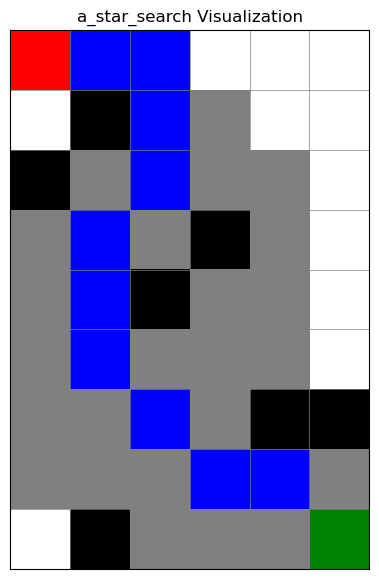

In [9]:
## Code from exercises week 5, modified A* algorithm, BoMR course
def heuristic(a, b):
    # Implement the Euclidean distance heuristic
    return np.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

def in_grid(grid, pos):
    return 0 <= pos[0] < grid.shape[0] and 0 <= pos[1] < grid.shape[1]

def is_obstacle(grid, pos):
    return not in_grid(grid, pos) or (grid[pos] == -1)

# A* algorithm implementation in a Grid
async def a_star_search(map_grid, start, goal):
    # Initialize the open set as a priority queue and add the start node
    open_set = []
    heappush(open_set, (heuristic(start, goal), 0, start))  # (f_cost, g_cost, position)

    # Initialize the came_from dictionary
    came_from = {}
    # Initialize g_costs dictionary with default value of infinity and set g_costs[start] = 0
    g_costs = {start: 0}
    # Initialize the explored set
    explored = set()
    operation_count = 0

    while open_set:
        # Pop the node with the lowest f_cost from the open set
        current_f_cost, current_g_cost, current_pos = heappop(open_set)

        # Add the current node to the explored set
        explored.add(current_pos)

        # For directly reconstruct path
        if current_pos == goal:
            break
        
        up         = (current_pos[0] - 1, current_pos[1]    )
        down       = (current_pos[0] + 1, current_pos[1]    )  # Down
        left       = (current_pos[0]    , current_pos[1] - 1)  # Left
        right      = (current_pos[0]    , current_pos[1] + 1)  # Right
        up_left    = (current_pos[0] - 1, current_pos[1] - 1)  # Up Left
        down_right = (current_pos[0] + 1, current_pos[1] + 1)  # Down Right
        down_left  = (current_pos[0] + 1, current_pos[1] - 1)  # Down Left
        up_right   = (current_pos[0] - 1, current_pos[1] + 1)   # Up Right
        # Get the neighbors of the current node (up, down, left, right)
        neighbors = [up, down, left, right, up_left, down_right, down_left, up_right]
        
        # exclude diagonal displacements if there is an adjacent obstacle (no corner cutting)
        if is_obstacle(map_grid, up) or is_obstacle(map_grid, left) :
                neighbors.remove(up_left)
        
        if is_obstacle(map_grid, up) or is_obstacle(map_grid, right):
                neighbors.remove(up_right)
                
        if is_obstacle(map_grid, down) or is_obstacle(map_grid, right):
                neighbors.remove(down_right)
                
        if is_obstacle(map_grid, down) or is_obstacle(map_grid, left):
                neighbors.remove(down_left)
            
                
        for neighbor in neighbors:
            # Check if neighbor is within bounds and not an obstacle
            if (in_grid(map_grid,neighbor)) and map_grid[neighbor[0], neighbor[1]] != -1 and neighbor not in explored:
                # Calculate tentative_g_cost
                tentative_g_cost = current_g_cost + heuristic(current_pos, neighbor)
                
                # If this path to neighbor is better than any previous one
                if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                    # Update came_from, g_costs, and f_cost
                    came_from[neighbor] = current_pos
                    g_costs[neighbor] = tentative_g_cost
                    f_cost = tentative_g_cost + heuristic(neighbor, goal)

                    # Add neighbor to open set
                    heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                    operation_count += 1

    # Reconstruct path
    if current_pos == goal:
        path = []
        while current_pos in came_from:
            path.append(current_pos)
            current_pos = came_from[current_pos]
        path.append(start)
        return path[::-1], explored,operation_count
    else:
        # If we reach here, no path was found
        return None, explored,operation_count
    
    

    
# Function for the visualization of the Map, including the Path, Obstacles and explored positions.    
def display_map(map_grid, path, start, goal, explored):
    cmap = ListedColormap(['white', 'black', 'blue', 'green', 'red', 'grey'])
    map_display = np.zeros_like(map_grid, dtype=object)

    # Assign colors based on the map grid values
    map_display[map_grid == -1] = 'black'  # Obstacles
    map_display[map_grid == 0] = 'white'   # Free space

    for position in explored:
        if map_display[tuple(position)] == 'white':
            map_display[tuple(position)] = 'grey'  # Explored cells

    # Visualize the path
    for position in path:
        if map_display[position[0], position[1]] in ['white', 'grey']:
            map_display[position[0], position[1]] = 'blue'  # Path

    map_display[start[0], start[1]] = 'green'  # Start
    map_display[goal[0], goal[1]] = 'red'      # Goal

    # Convert color names to numbers for plotting
    color_mapping = {'white': 0, 'black': 1, 'blue': 2, 'green': 3, 'red': 4, 'grey': 5, 'yellow': 6}
    map_numeric_display = np.vectorize(color_mapping.get)(map_display)
    fig, ax = plt.subplots(figsize=(6, 7))
    ax.imshow(map_numeric_display, cmap=cmap)
    ax.set_xticks(np.arange(-0.5, map_grid.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, map_grid.shape[0], 1), minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax.set_title('a_star_search Visualization')
    plt.show()

# Definition of Map Dimensions
map_height = 9
map_width = 6
Map = np.zeros((map_height, map_width))

# Definition of the obstacles
Map[8, 1] = -1; Map[6, 4:6] = -1; Map[4, 2:3] = -1; Map[3, 3] = -1; Map[1, 1] = -1; Map[2, 0] = -1

# Definition of Start ang Goal Positions
SearchStart =  (8, 5)
SearchGoal  =  (0, 0)

# Running A* Algorithm and extraction of the optimal path if it exists. (Optimal in the sense of lowest cost)
path, explored, operation_count = await a_star_search(Map, SearchStart, SearchGoal)

# Display the result
if path:
    print("Path found:")
    print(path)
    print(f"Number of operations: {operation_count}")
    display_map(Map, path, SearchStart, SearchGoal, explored)
else:
    print("No path found.")

With the most efficient path stored, the critical points, meaning changes in orientation, were stored in a new list that defined the goals for the controller. This list is produced by the following function. 

In [10]:
# Takes the path found# To keep track of how many redundant steps of the path have been removed  by the A* algorithm as an argument and removes the points with a repeated orientation

async def goal_list_from_path(path):
    goal_list = path.copy()
    popped = 0    # To keep track of how many redundant steps of the path have been removed 
    for i in range(len(path)-2):
        # Checks if three consecutive points lie in a straiExght line and removes middle because it is redundant
        if (path[i+1][0] - path[i][0] == path[i+2][0] - path[i+1][0]) and (path[i+1][1] - path[i][1] == path[i+2][1] - path[i+1][1]):
            goal_list.pop(i+1 - popped)
            popped += 1
    return goal_list

goal_list = await goal_list_from_path(path)

print("A* path:           ", path     )
print("Reduced goal list: ", goal_list)

A* path:            [(8, 5), (7, 4), (7, 3), (6, 2), (5, 1), (4, 1), (3, 1), (2, 2), (1, 2), (0, 2), (0, 1), (0, 0)]
Reduced goal list:  [(8, 5), (7, 4), (7, 3), (5, 1), (3, 1), (2, 2), (0, 2), (0, 0)]


## 3. Local Navigation
The local navigation relies on the horizontal sensors of the Thymio. If an object is detected, the robot changes the velocity of the motors to effectively avoid it. The motor velocity changes are made through the **weights**. Each weight determines how a sensor impacts the robots movement which is why the weights for each motor (output) are symmetric, but opposite in sign. In this way, when a sensor detects an obstacle the motors respond in a way that steer it away. 

The code can be seen as a single-layer neural network where the input is the proximity sensor (9 elements) and the output is each motor (2). Parts of the code were taken from the solutions to the third week exercises on Artificial Neural Networks. 

In [11]:
## For testing functionality of the sensors

# Function was obtained from the solutions of the week 3 exercises covering artificial neural networks
async def print_sensor_values(sensor_id, print_range=2, delta_time=0.2):
    """
    Print the sensor value sensor_id print_range times, every delta_time seconds
    """
    await node.wait_for_variables({str(sensor_id)})
    for i in range(print_range):
        print(list(node[sensor_id]))
        await client.sleep(delta_time)
        
await print_sensor_values('prox.horizontal')

[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]


In [12]:
## Function to obtain the sensor values from the selected type of sensors. Similar to function print_sensor_values obtained from solutions for week 3 exercises

async def get_sensor_values(sensor_id, delay=0.01):
    await client.sleep(delay)
    sensor_values = list(node[sensor_id])  # Retrieve the current values
    return sensor_values  # Return the collected sensor values as a list

horizontal_sensor_values = await get_sensor_values('prox.horizontal')

In [13]:
## Function to verify if there are any obstacles. Gets the current readings of the get_sensor_values function for the horizontal sensors
## If the value of the sensor is above the proximity threshold, it sends a 1

async def check_obstacles(proximity_threshold=1500):
    horizontal_sensor_values = await get_sensor_values('prox.horizontal')
    if any(x > proximity_threshold for x in horizontal_sensor_values):
        return 1  # Obstacle detected
    return 0  # No obstacle

In [14]:
## Function to avoid obstacles based on neural network
## Obtained from solutions for week 3 exercises and adapted to satisfy speed requirements and asynchronous functionality

async def obstacle_avoidance(left_output=0, right_output=0):
    # Define weights for left and right motors
    w_l = [30, 20, -20, -20, -30, 30, -10]
    w_r = [-30, -20, -20, 20, 30, -10, 30]

    # Scale factors for sensors and constant factor
    sensor_scale = 2500
    
    # Read proximity sensor values
    prox_values = list(node['prox.horizontal'])
    
    # Compute motor outputs based on the scaled sensor values
    for i in range(len(prox_values)):
        # Scale the sensor readings
        scaled_value = prox_values[i] // sensor_scale
        
        # Update outputs for left and right motors
        left_output += scaled_value * w_l[i]
        right_output += scaled_value * w_r[i]

    # Set motor powers
    await node.set_variables(motors(int(left_output), int(right_output)))
    print(f"Left Motor: {left_output}, Right Motor: {right_output}")
    
    return left_output, right_output

## 4. Kalman Filter

In [15]:
# Initialising the remaining constants
# units: x [mm],
#        y [mm],
#        phi [°],
#        v_x [mm/s]
#        v_y [mm/s]
#        phi_point [°/s]
#        Ts [s]


Ts = 0.1

# Matrix that creates model 
A = np.array([[1, 0, 0, Ts, 0, 0],
              [0, 1, 0, 0, Ts, 0],
              [0, 0, 1, 0, 0, Ts],
              [0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]])

# Variables for Q matrix to control the variance as a function of the sensors
q_x = 0.04
q_y = 0.04
q_phi = 1.
q_vx = 75.72
q_vy = 75.72
q_vphi = 0.40

#peut-être ajuster Q à chaque iteration en fonction de phi 
Q = np.array([[q_x, 0, 0, 0, 0, 0],
              [0, q_y, 0, 0, 0, 0],
              [0, 0, q_phi, 0, 0, 0],
              [0, 0, 0, q_vx, 0, 0],
              [0, 0, 0, 0, q_vy, 0],
              [0, 0, 0, 0, 0, q_vphi]])

r_x = 0.25
r_y = 0.25
r_phi = 5
r_vx = 75.72
r_vy = 75.72
r_vphi = 0.40

speed_conv_factor = 0.3375; #valeur moteur -> mm/s
angular_speed_conv_factor = 0.1923*np.pi/180 #delta valeur moteur -> rad/s

async def kalman_filter(speed_left, speed_right, camera_x, camera_y, camera_phi, camera_flag, x_est_prev, P_est_prev,
                  HT=None, HNT=None, RT=None, RNT=None):
    """
    Estimates the current state using input sensor data and the previous state
    
    param speed_left: measured speed of motor left(Thymio units)
    param speed_right: measured speed of motor right(Thymio units)
    param camera_x: measured x coordinate with the camera
    param camera_y: measured y coordinate with the camera
    param camera_phi: measured phi angle with the camera
    param camera_flag: flag to know if the camera is operational 
    param x_est_prev: previous state a posteriori estimation
    param P_est_prev: previous state a posteriori covariance
    
    return x_est: new a posteriori state estimation
    return P_est: new a posteriori state covariance
    """
    
    ## Prediciton through the a priori estimate
    # estimated mean of the state
    x_est_a_priori = np.dot(A, x_est_prev);
    
    # Estimated covariance of the state
    P_est_a_priori = np.dot(A, np.dot(P_est_prev, A.T));
    P_est_a_priori = P_est_a_priori + Q if type(Q) != type(None) else P_est_a_priori
    
    ## Update         
    # y, C, and R for a posteriori estimate, depending on transition
    if (x_est_a_priori[2][0] - camera_phi) > np.pi:
        camera_phi += 2 * np.pi

    if (x_est_a_priori[2][0] - camera_phi) < - np.pi:
        camera_phi -= 2 * np.pi
    
    #speed 
    speed = (speed_left + speed_right)/2
    speed_angular = (speed_left - speed_right) #si positif -> sens horaire 

    phi = x_est_a_priori[2][0]
    
    if (camera_flag): 
        
        y = np.array([[camera_x],
                      [camera_y],
                      [camera_phi],
                      [speed*speed_conv_factor*np.cos(phi)],
                      [speed *speed_conv_factor*np.sin(phi)],
                      [speed_angular*angular_speed_conv_factor]])
        H = np.array([[1, 0, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0, 0],
                      [0, 0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        R = np.array([[r_x, 0, 0, 0, 0, 0],
                      [0, r_y, 0, 0, 0, 0],
                      [0, 0, r_phi, 0, 0, 0],
                      [0, 0, 0, r_vx, 0, 0],
                      [0, 0, 0, 0, r_vy, 0],
                      [0, 0, 0, 0, 0, r_vphi]])
    else:
        # no transition, use only the speed
        y = np.array([[speed*speed_conv_factor*np.cos(phi)],
                      [speed *speed_conv_factor*np.sin(phi)],
                      [speed_angular*angular_speed_conv_factor]])
        H = np.array([[0, 0, 0, 1, 0, 0],
                      [0, 0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 0, 1]])
        R = np.array([[r_vx, 0, 0],
                      [0, r_vy, 0],
                      [0, 0, r_vphi]])

    # innovation / measurement residual
    i = y - np.dot(H, x_est_a_priori);
    # measurement prediction covariance
    S = np.dot(H, np.dot(P_est_a_priori, H.T)) + R;
             
    # Kalman gain (tells how much the predictions should be corrected based on the measurements)
    K = np.dot(P_est_a_priori, np.dot(H.T, np.linalg.inv(S)));
    
    
    # a posteriori estimate
    x_est = x_est_a_priori + np.dot(K,i);
    P_est = P_est_a_priori - np.dot(K,np.dot(H, P_est_a_priori));

    if (x_est[2][0]) > np.pi:
        x_est[2][0] -= 2 * np.pi

    if (x_est[2][0]) < - np.pi:
        x_est[2][0] += 2 * np.pi
     
    return x_est, P_est

## 5. Motion Control

### 5.1 PID Control

To effectively create a controller to ensure the robot is able to follow the path, a PID controller based on the orientation error of the robot was employed. A measure of the orientation is obtained through the camera and processed with the Kalman filter to effectively control the robot. A series of functions were used to create the controller based on the error measured between the desired orientation with respect to a certain goal and the orienation measurements and predictions. The appropriate gains were selected after testing their effect and identifying the desired response for the robot. The following considerations were taken into account:

#### Proportional Gain $k_p$  <!--  (\(k_p\))  -->
- Controls the strength of the robot's response to the current error.
- Determines the time taken to correct the error (avoiding overshooting or overly slow responses).

#### Integral Gain  $k_i$ <!--  (\(k_i\))  -->
- Controls the accumulation of errors in the past through an integration operation.
- Ensures there are no steady-state errors by compensating for persistent offsets.

#### Derivative Gain  $k_d$ <!--  (\(k_d\))  -->
- Controls the robot's reaction to the rate of change of the error.
- Determines the sensitivity of the controller, ensuring the correction rate is neither too aggressive nor too delayed.

To test the controller, a simulator was employed, and the correseponding codes a
 also included.


The following function takes as input the desired x and y positions as well as the current positions estimate (from the kalman filter) to get the errors. This will be used in the PID controller. For position, the Euclidean distance norm is used: 
\begin{equation} 
dist error = \sqrt{x_{err}^2 + y_{err}^2} 
\end{equation}

For orientation, the following equation is used:
\begin{equation} 
\phi_d = \arctan2(y_{\text{err}}, x_{\text{err}}) 
\end{equation} 
\begin{equation} 
\phi_{\text{err}} = \phi_d - \phi 
\end{equation}

The function $\arctan2(y,x)$ returns a value in the interval $(-\pi,\pi]$ for the angle $\theta$ of a vector $(x,y)$, with respect to the $x$ axis.

Finally, the orientation error is then normalized to the range -180° to 180° (in case the signs of desired and estimated orientations are different and the sum of their norm is greater than $\pi$).

In [16]:
## This function calculates the position and orientation errors based on the estimated and desired positions of the robot
# from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/

async def get_pose_error(xd, yd, x, y, phi):
    """ Returns the position and orientation errors. 
        Orientation error is bounded between -pi and +pi radians.
        xd: deisred x position
        yd: desired y position
        x:  estimated x position
        y:  estimated y position
        phi: estimated orientation
    """
    # Position error:
    x_err = xd - x 
    y_err = yd - y
    dist_err = np.sqrt(x_err**2 + y_err**2) # Euclidean distance

    # Orientation error
    phi_d = np.arctan2(y_err,x_err) # The desired orientation phi_d is computed online from the vector of position error
    phi_err = phi_d - phi

    # Limits the error to (-pi, pi):
    phi_err_correct = np.arctan2(np.sin(phi_err),np.cos(phi_err))

    return dist_err, phi_err_correct

This definition defines a PID controller defining the gains for each of the terms. It takes as input the current error, the error from the previous step, the accumulated error and the time step and applies the following equation. The Gains can be declared as a result of trial and error. The PID function is composed of the following:
\begin{equation} P = k_p \cdot e \end{equation}
\begin{equation} I = e_{\text{acc}} + k_i \cdot e \cdot \Delta t \end{equation}
\begin{equation} D = k_d \cdot \frac{e - e_{\text{prev}}}{\Delta t} \end{equation}
\begin{equation}
\text{Output} = k_p \cdot e + k_i \cdot \int e \, dt + k_d \cdot \frac{de}{dt}
\end{equation}

In [17]:
## This function implements a "goal to goal" behavior meaning that it controls the robot orientation by adjusting the angular speed only. 
    # The forward speed is supposed to remain constant, equal to a chosen value
# from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/

async def pid_controller(e, e_prev, e_acc, delta_t, kp=1.0, kd=0, ki=0):
    """ 
    PID algortithm: must be executed every delta_t seconds
    The error e must be calculated as: e = desired_value - actual_value
    e_prev contains the error calculated in the previous step.
    e_acc contains the integration (accumulation) term.
    """
    P = kp*e                      # Proportional term; kp is the proportional gain
    I = e_acc + ki*e*delta_t      # Intergral term; ki is the integral gain
    D = kd*(e - e_prev)/delta_t   # Derivative term; kd is the derivative gain

    output = P + I + D              # controller output, angular velocity in this case

    # store values for the next iteration
    e_prev = e     # error value in the previous interation (to calculate the derivative term)
    e_acc = I      # accumulated error value (to calculate the integral term)

    return output, e_prev, e_acc

Taking the output of the PID controller (angular speed), the speed for each wheel is calculated with the following equations. The linear speed remains constant to avoid complex behaviors and inaccurate position estimation. 
\begin{equation} w_{r_d} = \frac{2u_d - dw_d}{2r} \end{equation} 
\begin{equation} w_{l_d} = \frac{2u_d + dw_d}{2r} \end{equation}

In [18]:
## This function calculates the speeds for the left and right wheels based on the desired values of linear and angular speeds
    # The equations come from a model of the kinematics of a differential robot. 

# modified from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/
    # since we chose a different reference frame, we had to invert the wr_d and wl_d from the original code.

async def wheel_speed_commands(u_d, w_d, d, r, phi_erreur):
    """
    Convert desired robot speeds to desired wheel speeds
    """
    #u_d *= (1 - phi_erreur/np.pi)
    #w_d *= (phi_erreur/np.pi)
    wr_d = float((2 * u_d - d * w_d) / (2 * r))
    wl_d = float((2 * u_d + d * w_d) / (2 * r))
    
    # If saturated, correct speeds to keep the original turning ratio
    #if np.abs(wl_d) > MAX_SPEED or np.abs(wr_d) > MAX_SPEED:
     #   speed_ratio = np.abs(wr_d)/np.abs(wl_d)
      #  if speed_ratio > 1:
       #     wr_d = np.sign(wr_d)*MAX_SPEED
        #    wl_d = np.sign(wl_d)*MAX_SPEED/speed_ratio
        #else:
         #   wl_d = np.sign(wl_d)*MAX_SPEED
          #  wr_d = np.sign(wr_d)*MAX_SPEED*speed_ratio
        
    return wl_d, wr_d

Based on the speeds of the wheels, the function updates the robot's position virtually. 

\begin{equation} \text{Forward Speed} = \frac{r \cdot (w_r + w_l)}{2} \end{equation} 
\begin{equation} \text{Angular Speed} = \frac{r \cdot (w_l - w_r)}{d} \end{equation}

\begin{equation} x = \text{Forward Speed} \cdot \cos(\phi) \cdot \Delta t + x_{prev} \end{equation} 
\begin{equation} y = \text{Forward Speed} \cdot \sin(\phi) \cdot \Delta t + y_{prev} \end{equation}

\begin{equation} \phi = \text{Angular Speed} \cdot \Delta t + phi_{prev} \end{equation} 
\begin{equation} \phi = \arctan2(\sin(\phi), \cos(\phi)) \end{equation}

In [19]:
async def update_odometry(x, y, phi, wl, wr, d, r, delta_t):
    # Update robot's position and orientation using odometry
    forward_speed = (wr + wl) * r / 2
    angular_speed = (wl - wr) * r / d

    """
    The term that is added to the x and y positions in the update of the odometry are 
    both normalized by 14 (cm), because that is the length of the side of a square in 
    our physical grid, but we chose x and y to represent the square coordinate in the 
    grid, instead of the actual metric position
    """ 
    
    x += forward_speed * np.cos(phi) * delta_t / 14
    y += forward_speed * np.sin(phi) * delta_t / 14
    phi += angular_speed * delta_t

    # Keep phi within (-pi, pi)
    phi = np.arctan2(np.sin(phi), np.cos(phi))

    return x, y, phi

In [20]:
async def check_kidnapping():
    # Get the current ground sensor values
    ground_sensor_values = await get_sensor_values('prox.ground.reflected')

    # Debugging print to observe sensor values
    #print(f"Ground Sensor Values: {ground_sensor_values}")

    # Threshold to detect lifting
    ground_threshold = 25  

    # Check if both ground sensors are below the threshold
    if ground_sensor_values[1] < ground_threshold and ground_sensor_values[0] < ground_threshold:
        print("Kidnapping detected! Robot lifted off the ground. Check_kidnapping function")
        return 1  # Return 1 for kidnapping state
    else:
        return 0  # Normal operation

### 5.2 Main Control Loop combining the global and local navigation


The main control loop is the bases of the robot's navigation system allowing the robot to follow the global path created with A* while continuously checking for obstacles and adjusting its movement using odometry and PID control. The loop operates as follows:

1. **Path Following**: The robot navigates in the key points (turning points in the A*) in the goal list, moving from one goal to the next.
2. **Obstacle Detection**: The robot checks for nearby obstacles using proximity sensors. If an obstacle is detected, it triggers an obstacle avoidance routine.
3. **Pose Error Calculation**: The robot calculates the error considering the next point and the current robot orientation.
4. **PID Controller**: A PID controller processes the orientation error to compute an angular speed command, ensuring smooth and accurate movements. Given that the Thymio actuators are not precise, this controller helps ensure the accurate path is taken. Similarly, when a local obstacle is detected, the PID controller ensures the path is retaken.
5. **Wheel Speed Commands**: The desired (fixed) forward and (computed) angular speeds are converted into individual wheel speeds for the robot's motors.
6. **Odometry Updates**: The robot's position and orientation are updated in real time using odometry, based on the wheel movements.
7. **Goal Reached Check**: If the robot reaches a goal within a predefined tolerance, it advances to the next goal.

#### State Machine Archtecture
The overall structure of the main control loop is based on a state machine. 
- **State 0: Path Following**
The robot follows the predefined path (A*) with the PID control.
- **State 1: Obstacle Avoidance** 
Obstacle avoidance procedure based on Neural Networks.
- **State 2: Path Recalculation** 
Creates a new grid and recomputes the ideal path.

In [21]:
## Function from exercises week 8, BoMR course

def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

In [22]:
## For testing functionality of the motor (signal reception)
node.send_set_variables(motors(100, 100))

In [23]:
## For testing functionality
node.send_set_variables(motors(0, 0))

The main control loop defines several initial values which were established based on testing results. 

In [24]:
async def main_control_loop(transformation_matrix):
    """
    Main control loop structured as a finite state machine.
    """

    # Get frame for obstacle detection
    ret, frame = cap.read()
    if not ret:
        print("Obstacle detection capture failed")
    height, width = frame.shape[:2]
    frame = cv2.warpPerspective(frame, transformation_matrix, (width, height))
    
    # Starting state
    state = 10
    
    # Constant forward speed
    u_const = 4  # cm/s (adjust based on your robot's speed capabilities)

    # Grid size
    grid_width = 9
    grid_height = 6

    # Frame size
    frame_height, frame_width = frame.shape[:2]
    
    # Map
    centroids, square_width, square_height = grid_centroids(grid_width, grid_height, frame_width, frame_height)
    obstacles = detect_obstacles(frame, centroids, square_width, square_height)
    Map = generate_map(obstacles)

    # Robot geometric parameters
    base_width = 9.4   # cm
    wheel_radius = 2.2 # cm

    # Speed constant (convert thymio motor speed to forward speed)
    speed_constant = 0.03375 # cm/s

    # Time step
    delta_t = 0.1  # seconds

    # Initial errors for PID
    phi_err_prev = 0
    phi_err_acc = 0

    # Signal to finish running the code indefinetely
    done = False

    #time.sleep(3) # So the person can move and the camera can detect the position
    for i in range(5):
        SearchStart, StartAngle, tracking = await cam_robot_pos(transformation_matrix)
        if tracking:
            break
        print("Couldn't find the robot initialisation")
    XStart = SearchStart[0]
    YStart = SearchStart[1]
    SearchStart = np.round(np.array([SearchStart[1]/140, SearchStart[0]/140])).astype(int)

    # Goal detection
    for i in range(5):
        SearchGoal = detect_goal(frame, square_width, square_height, BLUE_REF_HSV)
        if SearchGoal is not None:
            print("Goal found")
            break
        print("Couldn't find the goal")
    SearchGoal = [SearchGoal[1], SearchGoal[0]]
    
    # Obtaining path
    print('Obtaining path initialisation')
    path, explored, operation_count = await a_star_search(Map, tuple(SearchStart), tuple(SearchGoal))
    # Extract the key_points
    goal_list = await goal_list_from_path(path)
    
    # Kalman initialisation
    x_est = np.array([[XStart],
                      [YStart],
                      [StartAngle],
                      [0],
                      [0],
                      [0]])

    P_est = 1000 * np.ones(6)

    while not done:
        if state == 10:
            node.send_set_variables(motors(0, 0))
            time.sleep(3) # This can be removed, only used to adjust robot at the beginning and put back from kidnapping

            # While loop used to detect whether the robot is on the ground, if it is not, it will be in the loop 
            threshold = 400
            while True:
                # Get ground sensor values
                ground_sensor_values = await get_sensor_values('prox.ground.reflected')
                print(ground_sensor_values)
                
                if ground_sensor_values[1] >= threshold and ground_sensor_values[0] >= threshold:
                    print("Robot on the ground.:)")
                    break  # if the robot is placed on the ground
            
                print('I am being kidnapped :(, put me on the ground to continue')
                time.sleep(delta_t) 

            #time.sleep(3) # So the person can move and the camera can detect the position
            for i in range(5):
                SearchStart, _, tracking = await cam_robot_pos(transformation_matrix)
                if tracking:
                    break
                print("Couldn't find the robot")
            SearchStart = np.round(np.array([SearchStart[1]/140, SearchStart[0]/140])).astype(int)
            # Goal detection
            for i in range(5):
                SearchGoal = detect_goal(frame, square_width, square_height, BLUE_REF_HSV)
                if SearchGoal is not None:
                    print("Goal found ")
                    break
                print("Couldn't find the goal")
            SearchGoal = [SearchGoal[1], SearchGoal[0]]
            # Obtaining path
            print('Obtaining path')
            path, explored, operation_count = await a_star_search(Map, tuple(SearchStart), tuple(SearchGoal))
            # Extract the key_points
            goal_list = await goal_list_from_path(path)
            print(goal_list)

            # Initial robot position and orientation
            #x = x_est[0][0]
            #y = x_est[1][0]
            #phi = -np.pi/2  # Initial orientation, pointing north
        
            # Start with the first goal
            next_goal = 1
            x_goal = goal_list[next_goal][1]
            y_goal = goal_list[next_goal][0]
        
            control_x = [x_est[0][0]/140]
            control_y = [x_est[1][0]/140]
            it = 0
    
            state = 0
    
        while next_goal < len(goal_list):
    
            # Check if there are any obstacles
            bool_obstacles = await check_obstacles(proximity_threshold=2000)
            
            # Check to see if robot position changed very suddenly & ground sensors detected lifting
            bool_kidnap = await check_kidnapping()

            # Combining states
            if bool_kidnap == 1:
                state = 2  # Kidnapping 
            elif bool_obstacles == 1:
                state = 1  # Obstacle 
            else:
                state = 0  # Normal operation
            
            # print(f"The current state is: {state}")
            
            if state == 0:
                it += 1

                x = x_est[0][0]/140
                y = x_est[1][0]/140
                phi = x_est[2][0]
                #print("iteration", it)
                # Calculate pose error, only used orientation because the distance error is not necessary
                _, phi_err = await get_pose_error(x_goal, y_goal, x, y, phi) # the first returned value is the error in position, but we do not use this information 
                #print("pose error", _, phi_err)
                # Update orientation PID
                phi_control, phi_err_prev, phi_err_acc = await pid_controller(
                    phi_err, phi_err_prev, phi_err_acc, delta_t, kp=0.90, kd=0.05, ki=0.0)
    
                # Map control outputs to desired forward and angular speeds
                u_d = u_const  # Constant forward speed
                w_d = phi_control  # Angular speed from PID
    
                # Compute wheel speed commands
                left_angular, right_angular = await wheel_speed_commands(u_d, w_d, base_width, wheel_radius, phi_err) # returns angular velocity for each wheel
    
                # Simulate robot motion using odometry
                        # DEBUG
                print("predicted x: ", x)
                print("predicted y: ", y)
                print("goal x: ", x_goal)
                print("goal y: ", y_goal)
                
                # Scale to motor commands
                left_speed  = left_angular  * wheel_radius / speed_constant
                right_speed = right_angular * wheel_radius / speed_constant
    
                node.send_set_variables(motors(int(left_speed), int(right_speed)))
    
                print(f"Left Motor Speed: {int(left_speed)} Right Motor Speed: {int(right_speed)}")
    
                # Check if goal is reached
                dist_to_goal = np.sqrt((x_goal - x)**2 + (y_goal - y)**2)*14
                if dist_to_goal < 3:  # 3 cm tolerance
                    # print(" ")
                    print('******************************* goal reached *******************************')
                    next_goal += 1
                    print(f"Before loop check, next_goal = {next_goal}, len(goal_list) = {len(goal_list)}")
                    if next_goal < len(goal_list):
                        x_goal = goal_list[next_goal][1]
                        y_goal = goal_list[next_goal][0]
                    elif next_goal == len(goal_list):
                        print('Goal Reached!')
                        done = True # Flag to terminate outer loop
                        break
                # print(" ")
    
                # Wait for the next iteration (optional for simulation)
            elif state == 1:
                print("Obstacle detected - obstacle avoidance")
                left_speed, right_speed = await obstacle_avoidance(left_speed, right_speed)

                left_angular = left_speed * speed_constant / wheel_radius
                right_angular = right_speed * speed_constant / wheel_radius
            elif state == 2:
                print('Kidnapping')
                state = 10
                break

            speed_left = node["motor.left.speed"] 
            speed_right = node["motor.right.speed"] 

            pos_cam, ang_cam, cam_flag = await cam_robot_pos(transformation_matrix)
            print("camera values:", pos_cam[0]/140, pos_cam[1]/140, ang_cam, cam_flag)
            x_est, P_est = await kalman_filter(speed_left, speed_right, pos_cam[0], pos_cam[1], ang_cam, cam_flag, x_est, P_est)
            print("angle Kalman", x_est[2][0])
            
            control_x.append(x_est[0][0]/140)
            control_y.append(x_est[1][0]/140)
            
            
            time.sleep(delta_t)
            
    # Stop robot at the end    
    left_speed = 0
    right_speed = 0
    node.send_set_variables(motors(int(left_speed), int(right_speed)))

    return control_x, control_y, goal_list

In [25]:
camera_index = 0 #int(sys.argv[1]) if len(sys.argv) > 1 else 0
cap = cv2.VideoCapture(camera_index, cv2.CAP_DSHOW)
# Open window for visualization
win_name = "Camera"
cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
# Initialize variables
positions = np.empty((0, 2), dtype=int)
angles = np.empty((0, 1), dtype=float)
GREEN_REF = (80,140,80)
RED_REF = (180,180,130)
MAG_REF_HSV = (172, 170, 120)
BLUE_REF_HSV = (90, 180, 60)
MAX_CIRCLE_DISTANCE = 50

transformation_matrix = cam_init()

control_x, control_y, goal_list = await main_control_loop(transformation_matrix)

Camera opened successfully.
Succes: 4 squares found !
Squares detected. Computing transformation matrix.
for loop len: 54
Succes: 1 squares found !
Goal found
Obtaining path initialisation
[976, 951]
Robot on the ground.:)
Succes: 1 squares found !
Goal found
Obtaining path
[(5, 1), (3, 1), (2, 2), (0, 2), (0, 0), (1, 0)]
predicted x:  1.01875
predicted y:  4.95625
goal x:  1
goal y:  3
Left Motor Speed: 408 Right Motor Speed: -171
camera values: 1.01875 4.9703125 -3.064820762320015 True
angle Kalman -2.372284511909384
predicted x:  1.0239009108804016
predicted y:  4.963340566052814
goal x:  1
goal y:  3
Left Motor Speed: 168 Right Motor Speed: 68
camera values: 1.01875 4.9703125 -3.064820762320015 True
angle Kalman -2.533717376311641
predicted x:  1.0208978886724427
predicted y:  4.967629513448793
goal x:  1
goal y:  3
Left Motor Speed: 249 Right Motor Speed: -12
camera values: 1.01875 4.9421875 -2.9147938055359073 True
angle Kalman -2.6467317981164307
predicted x:  1.0186092041731967

In [26]:
## For testing functionality
node.send_set_variables(motors(0, 0))

In [27]:
cap.release()
cv2.destroyWindow(win_name)

### 5.3 Mapping the robot's trajectory
The following code creates a map based on the stored values for the robot's motion. This way it is possible to see where the obstacles were detected and which actions were taken to avoid them. 

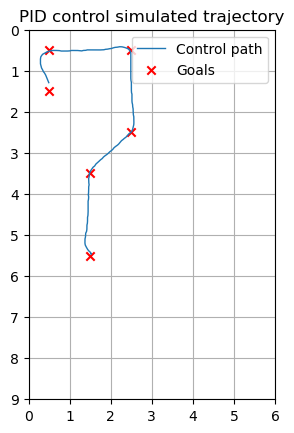

In [28]:
ax = plt.gca()
ax.invert_yaxis()
ax.set_aspect('equal', adjustable='box')

ct_x = control_x.copy()
ct_y = control_y.copy()

for i in range(len(control_x)):
    ct_x[i] += 0.5
    ct_y[i] += 0.5
    
plt.plot(ct_x, ct_y, linewidth = 1)

x_goals = []
y_goals = []

for goal in goal_list:
    x_goals.append(goal[1]+0.5)
    y_goals.append(goal[0]+0.5)
    
plt.scatter(x_goals, y_goals, color="r", marker="x")

ax.legend(['Control path', 'Goals'])
plt.title("PID control simulated trajectory")

plt.xticks(np.arange(0, 7, step=1))
plt.yticks(np.arange(0, 10, step=1))
plt.grid()

plt.savefig('motion_control.png', dpi=400)
plt.show()

## Bibliography

PID Explained. (n.d.). PID Controller Explained. Retrieved from https://pidexplained.com/pid-controller-explained/

Martins, F. (n.d.). Lab 4: Robotics Simulation Labs. Retrieved November 22, 2024, from https://felipenmartins.github.io/Robotics-Simulation-Labs/Lab4/

Mondada, F. (2024). Code for A* Algorithm (Exercise 5). Provided in Mobile Robotics, EPFL. Unpublished class material.

Mondada, F. (2024). Code for Artificial Neural Networks and Motor Movement (Exercise 3). Provided in Mobile Robotics, EPFL. Unpublished class material.